# 1. 데이터셋 구성
### 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import math

import torch.nn as nn
import torch.nn.functional as F

from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from model import Encoder, Decoder, Discriminator

trained_model = torch.load('all.tar')
netE = trained_model['netE']
netD = trained_model['netD']
netDis = trained_model['netDis']
netE.load_state_dict(trained_model['netE_st_dict'])
netD.load_state_dict(trained_model['netD_st_dict'])
netDis.load_state_dict(trained_model['netDis_st_dict'])
netE.eval()
netD.eval()
netDis.eval()

Discriminator(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=120, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=1, bias=True)
    (4): Sigmoid()
  )
)

### 랜덤 시드값 설정

In [2]:
random_seed = 123
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

df_1 = pd.read_csv('data/normal_vec.csv', header=None)
df_2 = pd.read_csv('data/abnormal_vec.csv', header=None)
df_3 = pd.read_csv('data/error_vec.csv', header=None)
df_real = pd.read_csv('data/real_data.csv', header=None)

### 데이터 표준화

In [3]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(pd.concat([df_1, df_2, df_3]))

StandardScaler()

### normal, abnormal, error Padding

In [4]:
def normal_make_instance(df):
    noise = np.random.normal(0, 7, (15,6))
    list_scaled = scaler.transform(df + noise)
    abc = np.concatenate((np.array([[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]]),list_scaled,np.array([[0,0,0,0,0,0],[0,0,0,0,0,0]])))
    b = torch.from_numpy(abc)
    instance = [b, 0]
    return instance

def abnormal_make_instance(df):
    noise = np.random.normal(0, 7, (19,6))
    list_scaled = scaler.transform(df + noise)
    abc = np.concatenate((list_scaled, np.array([[0,0,0,0,0,0]])))
    b = torch.from_numpy(abc) 
    instance = [b, 1]
    return instance

def error_make_instance(df):
    noise = np.random.normal(0, 7, (20,6))
    list_scaled = scaler.transform(df + noise)
    b = torch.from_numpy(list_scaled)
    instance = [b, 2]
    return instance

### train/val/test 데이터셋 생성
### 각각 30000/6000/6000개 인스턴스 포함

In [5]:
import copy

def make_ds_nor(df_nor, num):
    dataset = []
    for i in range(num):
        aa = copy.copy([netD(netE(normal_make_instance(df_nor)[0].unsqueeze(0).float())).squeeze(),  
                        normal_make_instance(df_nor)[1]])
        dataset.append(aa)
        if i % 1000 == 999 :
            print('data gernerate : {}'.format(i + 1))
    return dataset

def make_ds_abn(df_abn, num):
    dataset = []
    for i in range(num):
        aa = copy.copy([netD(netE(abnormal_make_instance(df_abn)[0].unsqueeze(0).float())).squeeze(),  
                        abnormal_make_instance(df_abn)[1]])
        dataset.append(aa)
        if i % 1000 == 999 :
            print('data gernerate : {}'.format(i + 1))
    return dataset

def make_ds_err(df_err, num):
    dataset = []
    for i in range(num):
        aa = copy.copy([netD(netE(error_make_instance(df_err)[0].unsqueeze(0).float())).squeeze(),  
                        error_make_instance(df_err)[1]])
        dataset.append(aa)
        if i % 1000 == 999 :
            print('data gernerate : {}'.format(i + 1))
    return dataset

In [6]:
total_dataset = make_ds_nor(df_1, 30000)
abn_ds = make_ds_abn(df_2, 6000)
err_ds = make_ds_err(df_3, 6000)

data gernerate : 1000
data gernerate : 2000
data gernerate : 3000
data gernerate : 4000
data gernerate : 5000
data gernerate : 6000
data gernerate : 7000
data gernerate : 8000
data gernerate : 9000
data gernerate : 10000
data gernerate : 11000
data gernerate : 12000
data gernerate : 13000
data gernerate : 14000
data gernerate : 15000
data gernerate : 16000
data gernerate : 17000
data gernerate : 18000
data gernerate : 19000
data gernerate : 20000
data gernerate : 21000
data gernerate : 22000
data gernerate : 23000
data gernerate : 24000
data gernerate : 25000
data gernerate : 26000
data gernerate : 27000
data gernerate : 28000
data gernerate : 29000
data gernerate : 30000
data gernerate : 1000
data gernerate : 2000
data gernerate : 3000
data gernerate : 4000
data gernerate : 5000
data gernerate : 6000
data gernerate : 1000
data gernerate : 2000
data gernerate : 3000
data gernerate : 4000
data gernerate : 5000
data gernerate : 6000


In [7]:
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset

sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = random_seed)
indices = list(range(len(total_dataset)))
y_ds = [y for _, y in total_dataset]

for train_index, test_index in sss.split(indices, y_ds):
    print('train:', train_index, 'test:', test_index)
    print(len(train_index), len(test_index))

sub_train = Subset(total_dataset, train_index)
test_ds = Subset(total_dataset, test_index)

sss2 = StratifiedShuffleSplit(n_splits = 1, test_size = 0.25, random_state = random_seed)
indices2 = list(range(len(sub_train)))
y_ds2 = [y for _, y in sub_train]

for train_index2, val_index in sss2.split(indices2, y_ds2):
    print('train:', train_index2, 'val:', val_index)
    print(len(train_index2), len(val_index))

train_ds = Subset(sub_train, train_index2)
val_ds = Subset(sub_train, val_index)

train: [28760 11189 27698 ...  3696  3255  6056] test: [ 8569 10713  5779 ... 16435 26523 14030]
24000 6000
train: [12364 23772 18756 ...  4878 10895   663] val: [23759 13910 13237 ... 18298  5260  7459]
18000 6000


In [8]:
data, label = train_ds[0]
data.size()

torch.Size([20, 6])

In [9]:
from torch.utils.data import DataLoader
batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True, drop_last=True)

# 2. 모델 구성

### 모델 생성, hyperparameter 설정

In [10]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()
        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = (
            embedding_dim, 2 * embedding_dim
        )
        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.rnn2 = nn.LSTM(
          input_size=self.hidden_dim,
          hidden_size=embedding_dim,
          num_layers=1,
          batch_first=True
        )
    def forward(self, x):
        x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)
        return  x[:,-1,:]
    
class TimeDistributed(nn.Module):
    def __init__(self, module, batch_first=False):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):
        if len(x.size()) <= 2:
            return self.module(x)
        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)
        y = self.module(x_reshape)
        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)
        return y
    

class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()
        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features
        self.rnn1 = nn.LSTM(
          input_size=input_dim,
          hidden_size=input_dim,
          num_layers=1,
          batch_first=True
        )
        self.rnn2 = nn.LSTM(
          input_size=input_dim,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.output_layer = torch.nn.Linear(self.hidden_dim, n_features)
        self.timedist = TimeDistributed(self.output_layer)
        
    def forward(self, x):
        x=x.reshape(-1,1,self.input_dim).repeat(1,self.seq_len,1)       
        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        return self.timedist(x)

class RecurrentAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(RecurrentAutoencoder, self).__init__()
        self.encoder = Encoder(seq_len, n_features, embedding_dim)#.to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features)#.to(device)
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [11]:
model = RecurrentAutoencoder(20, 6, 64).cuda()
model.load_state_dict(torch.load('autolstm2.pt'))
model.eval()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)
#lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=20, min_lr=1e-6, verbose=True)
criterion = nn.L1Loss(reduction='sum')
num_epochs = 1000

In [12]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def Accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].contiguous().view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [13]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# 3. 모델 학습

In [14]:
"""
train_loss_curve = []
val_loss_curve = []

early_stopping = EarlyStopping(patience = 10, verbose = True, path = 'autolstm3.pt')
for epoch in range(num_epochs):
    model.train()
    train_losses = AverageMeter()
    for idx, (data, target) in enumerate(train_loader):
        #data = data.permute(1,0,2).cuda()
        data = data.cuda()
        target = target.cuda()
        data = data.type(torch.cuda.FloatTensor)
        y_pred = model(data)
        #print("y_pred",y_pred)

        train_loss = criterion(y_pred, data)
        #print(train_loss)

        train_losses.update(train_loss.item(), data.size(0)) 

        model.zero_grad()
        train_loss.backward(retain_graph=True)  # backward pass
        optimizer.step()  # parameter update

    train_loss_curve.append(train_losses.avg)
    #lr_scheduler.step(train_loss)

    with torch.no_grad():
        model.eval()

        val_losses = AverageMeter()
        
        for idx, (data, target) in enumerate(val_loader):
            #data = data.permute(1,0,2).cuda()
            data = data.cuda()
            target = target.cuda()
            data = data.type(torch.cuda.FloatTensor)

            y_pred = model(data)

            val_loss = criterion(y_pred, data)
            val_losses.update(val_loss.item(), data.size(0)) 

        val_loss_curve.append(val_losses.avg)
        early_stopping(val_losses.avg, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    print('Epoch : {} , train_loss : {:.3f}, val_loss : {:.3f}'.format(epoch+1, train_losses.avg,  val_losses.avg))
"""

'\ntrain_loss_curve = []\nval_loss_curve = []\n\nearly_stopping = EarlyStopping(patience = 10, verbose = True, path = \'autolstm3.pt\')\nfor epoch in range(num_epochs):\n    model.train()\n    train_losses = AverageMeter()\n    for idx, (data, target) in enumerate(train_loader):\n        #data = data.permute(1,0,2).cuda()\n        data = data.cuda()\n        target = target.cuda()\n        data = data.type(torch.cuda.FloatTensor)\n        y_pred = model(data)\n        #print("y_pred",y_pred)\n\n        train_loss = criterion(y_pred, data)\n        #print(train_loss)\n\n        train_losses.update(train_loss.item(), data.size(0)) \n\n        model.zero_grad()\n        train_loss.backward(retain_graph=True)  # backward pass\n        optimizer.step()  # parameter update\n\n    train_loss_curve.append(train_losses.avg)\n    #lr_scheduler.step(train_loss)\n\n    with torch.no_grad():\n        model.eval()\n\n        val_losses = AverageMeter()\n        \n        for idx, (data, target) in e

# 4. 모델 평가

### 데이터 복원

In [15]:
sample_loader = DataLoader(train_ds, batch_size= 1, shuffle=True, drop_last=True)
err_loader = DataLoader(err_ds, batch_size=1, shuffle = True, drop_last = True)

In [24]:
nor_sample = next(iter(sample_loader))
err_sample = next(iter(err_loader))

In [25]:
predict_nor = model(nor_sample[0].reshape(1,20,6).cuda().float())
predict_err = model(err_sample[0].reshape(1,20,6).cuda().float())

### 정상 데이터 예측 
#### 학습된 모델을 통한 데이터 복원이 원래 데이터와 거의 일치함 (학습 very good)

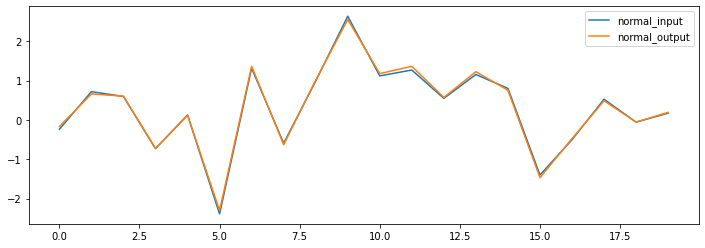

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

# node 1에 대해서만 plot
t = np.arange(0, 20, 1)
nor_input = pd.DataFrame(nor_sample[0][0]).iloc[:, 0]
nor_output = pd.DataFrame(predict_nor[0]).iloc[:, 0] 
plt.plot(t, nor_input)
plt.plot(t, nor_output)

plt.legend(['normal_input', 'normal_output'])
plt.show()

### 오류 데이터 예측
#### 학습된 모델을 통한 데이터 복원이 잘 이루어지지 않음 (정상데이터와 불량 데이터를 잘 구분함)

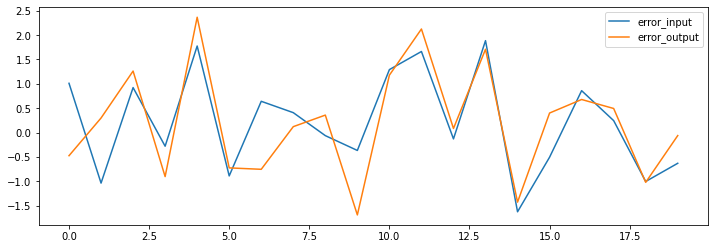

In [27]:
plt.figure(figsize=(12,4))

# node 1에 대해서만 plot
t = np.arange(0, 20, 1)
nor_input = pd.DataFrame(err_sample[0][0]).iloc[:, 0]
nor_output = pd.DataFrame(predict_err[0]).iloc[:, 0] 
plt.plot(t, nor_input)
plt.plot(t, nor_output)

plt.legend(['error_input', 'error_output'])
plt.show()

### 평가 및 threshold 결정

In [20]:
abn_loader = DataLoader(abn_ds, batch_size=1, shuffle=True, drop_last=True)
err_loader = DataLoader(err_ds, batch_size=1, shuffle=True, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=True, drop_last=True)

In [21]:
#criterion2 = nn.MSELoss()
with torch.no_grad():
    model.eval()
    abn_losses = []
    err_losses = []
    test_losses = []
    
    for idx, (data, target) in enumerate(test_loader):
        data = data.cuda()
        target = target.cuda()
        data = data.type(torch.cuda.FloatTensor)
        y_pred = model(data)

        loss = criterion(y_pred, data)
        test_losses.append(loss.item())
    
    for idx, (data, target) in enumerate(abn_loader):
        data = data.cuda()
        target = target.cuda()
        data = data.type(torch.cuda.FloatTensor)
        y_pred = model(data)

        loss = criterion(y_pred, data)
        abn_losses.append(loss.item())
    
    for idx, (data, target) in enumerate(err_loader):
        data = data.cuda()
        target = target.cuda()
        data = data.type(torch.cuda.FloatTensor)
        y_pred = model(data)

        loss = criterion(y_pred, data)
        err_losses.append(loss.item())

abn_loss = np.mean(abn_losses)
err_loss = np.mean(err_losses)

In [22]:
print('test_loss',np.mean(test_losses))
print('abn_loss:',abn_loss)
print('err_loss:',err_loss)

test_loss 5.142725357274214
abn_loss: 46.76182905960083
err_loss: 41.35799009291331


### anomaly score 분포 (초록: 정상, 노랑: 주의, 빨강: 오류) (낮을수록좋음, 정상과 불량 분류 잘함)

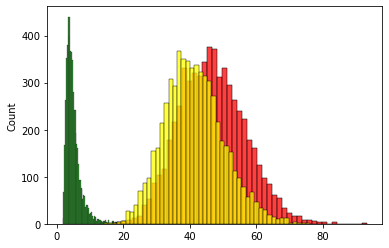

In [23]:
import seaborn as sns

sns.histplot(test_losses, color="green")
sns.histplot(abn_losses, color="red")
sns.histplot(err_losses, color="yellow")
plt.show()